In [1]:
import pandas as pd
import os
import numpy as np
from ast import literal_eval
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

random.seed(42)

In [2]:
# Readging the csv 

train = pd.read_csv("data/train.csv")
val = pd.read_csv("data/val.csv")
submission = pd.read_csv("data/sample_submission.csv")

train

,embeddings,label
0,"[0.3206779360771179, 0.988215982913971, 1.0441...",positive
1,"[0.05074610561132431, 1.0742985010147095, 0.60...",negative
2,"[0.41962647438049316, 0.4505457878112793, 1.39...",negative
3,"[0.4361684024333954, 0.19191382825374603, 0.83...",positive
4,"[0.6382085084915161, 0.8352395296096802, 0.393...",neutral
...,...,...
4995,"[2.2057647705078125, 1.1072001457214355, 0.435...",neutral
4996,"[0.6344252228736877, 1.164398193359375, 0.7155...",negative
4997,"[0.9160683155059814, 0.39996421337127686, 0.82...",negative
4998,"[0.006456990726292133, 0.18667978048324585, 0....",positive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# Getting the feature and labels from each set. 


X = np.array([literal_eval(embedding)  for embedding in train['embeddings'].values])
y = np.array(train['label'].values)

X_val = np.array([literal_eval(embedding)  for embedding in val['embeddings'].values])
y_val = np.array(val['label'].values)

In [5]:
X.shape, y.shape, X_val.shape, y.shape

((5000, 512), (5000,), (2000, 512), (5000,))

In [6]:
mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

<ErrorbarContainer object of 3 artists>

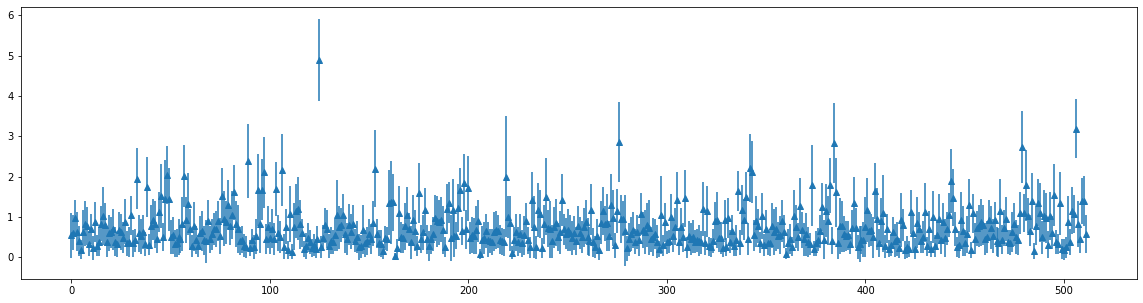

In [7]:
plt.figure(figsize=(20,5))
plt.errorbar(range(512), mean, std, linestyle='None', marker='^')

In [8]:
y[y=='positive']=2
y[y=='negative']=0
y[y=='neutral']=1

y_val[y_val=='positive']=2
y_val[y_val=='negative']=0
y_val[y_val=='neutral']=1

y=y.astype(np.int32)
y_val=y_val.astype(np.int32)

In [9]:
y[:10]

array([2, 0, 0, 2, 1, 0, 0, 0, 2, 0], dtype=int32)

In [10]:
def normalize_X(X):
    return (X-mean)/std

In [11]:
tx = torch.Tensor(normalize_X(X))
ty = torch.Tensor(y).long()

tx_val = torch.Tensor(normalize_X(X_val))
ty_val = torch.Tensor(y_val).long()

ds_train = TensorDataset(tx,ty)
train_loader = DataLoader(ds_train, batch_size=1000)

ds_val = TensorDataset(tx_val,ty_val)
val_loader = DataLoader(ds_val, batch_size=1000)

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(use_cuda,device)

True cuda


In [13]:
from tqdm import tqdm

In [14]:
from livelossplot import PlotLosses


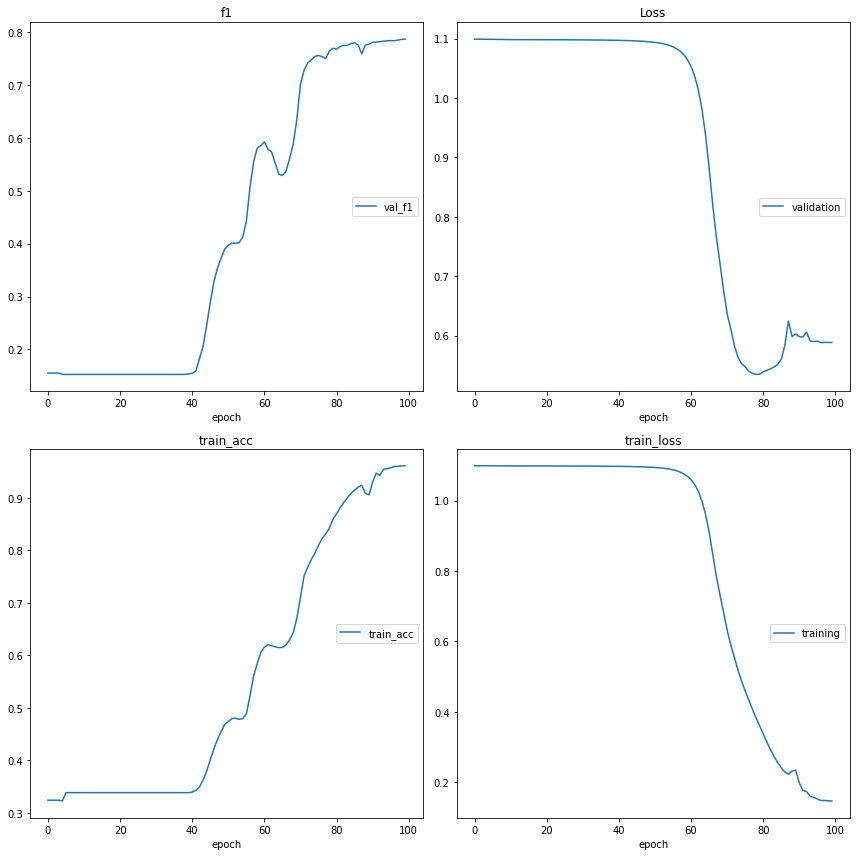

f1
	val_f1           	 (min:    0.153, max:    0.787, cur:    0.787)
Loss
	validation       	 (min:    0.535, max:    1.099, cur:    0.588)
train_acc
	train_acc        	 (min:    0.323, max:    0.961, cur:    0.961)
train_loss
	training         	 (min:    0.147, max:    1.099, cur:    0.147)


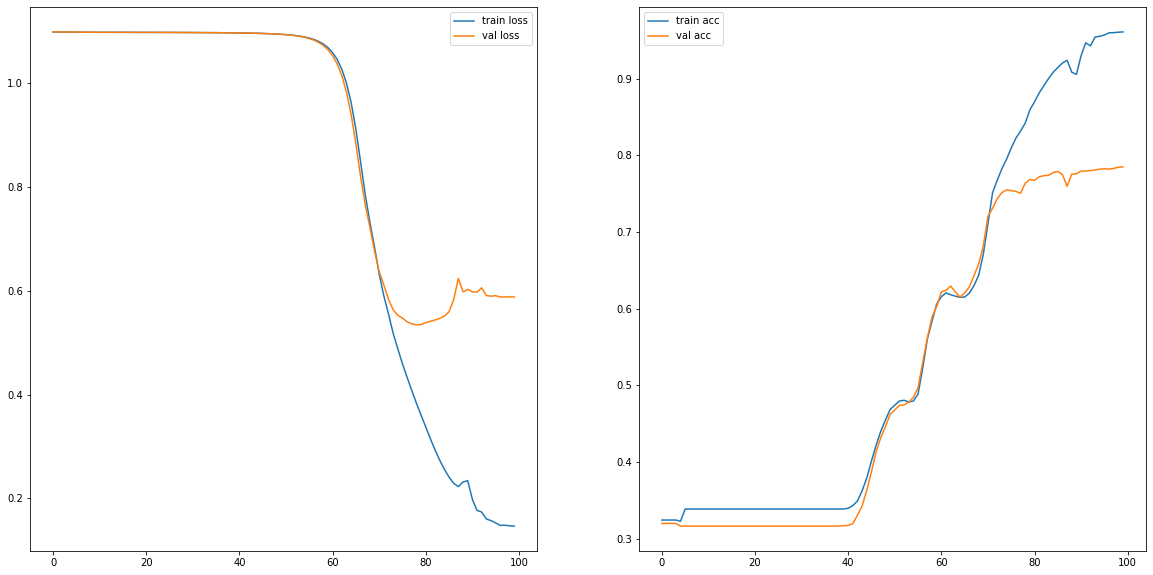

In [22]:
epochs=100
batch_size=5000

criterion = nn.CrossEntropyLoss()#label_smoothing=0.1)

class NetDDD3(nn.Module):
    def __init__(self):
        super(NetDDD3, self).__init__()
        self.m = nn.Sequential(nn.Linear(512, 2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048,3))

    def forward(self, x):
        return self.m(x)
    
class NetDDD2(nn.Module):
    def __init__(self):
        super(NetDDD2, self).__init__()
        self.m = nn.Sequential(nn.Linear(512, 5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,5000),
                                   nn.ReLU(),
                                   nn.Linear(5000,3))

    def forward(self, x):
        return self.m(x)

class NetDDD(nn.Module):
    def __init__(self):
        super(NetDDD, self).__init__()
        self.m = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,3))

    def forward(self, x):
        return self.m(x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.m1 = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,256),
                                   nn.ReLU(),
                                   nn.Dropout(0.3),
                                   nn.Linear(256,3))
        
        self.m2 = nn.Sequential(nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Linear(256,3))
        self.m3 = nn.Sequential(nn.Linear(512, 3))

        
        self.m4 = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,256),
                                   nn.ReLU(),
                                   nn.Dropout(0.3),
                                   nn.Linear(256,3))
        
        self.m5 = nn.Sequential(nn.Linear(512, 2048),
                                   nn.ReLU(),
                                   nn.Linear(2048,256),
                                   nn.ReLU(),
                                   nn.Dropout(0.8),
                                   nn.Linear(256,3))

        self.fc = nn.Linear(3*5,3)

    def forward(self, x):
        a = torch.cat((self.m1(x),self.m2(x),self.m3(x),self.m4(x),self.m5(x)),1)
        return self.fc(nn.Dropout(0.3)(nn.ReLU()(a)))

model = NetDDD3().to(device)
lr = 3e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)


train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]

liveloss = PlotLosses()

for epoch in range(1, epochs + 1):
    model.train()
    train_loss=0
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss+=loss.item()
    train_loss/=len(train_loader)
    acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(acc)
    
    model.eval()
    val_loss = 0
    correct = 0
    val_f1 = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            vl=criterion(output, target).item()
            val_loss += vl
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            val_f1+=f1_score(target.view_as(pred).cpu(), pred.cpu(), average='weighted')
        

    val_loss /= float(len(val_loader))
    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    val_f1 /= float(len(val_loader))
    
    logs={}
    logs['train_loss'] = train_loss
    logs['val_loss'] = val_loss
    logs['train_acc'] = acc
#     logs['val_acc'] = val_acc
    logs['val_f1'] = val_f1
    
    liveloss.update(logs)
    if epoch%5==0:
        liveloss.send()
#     if epoch%10==0:
#         print("Epoch %3d Train loss: %f Acc: %f    Val loss: %f Acc: %f"%(epoch, train_loss, acc, val_loss, val_acc))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend();
plt.subplot(1,2,2)
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend();
# plt.ylim(0,1);

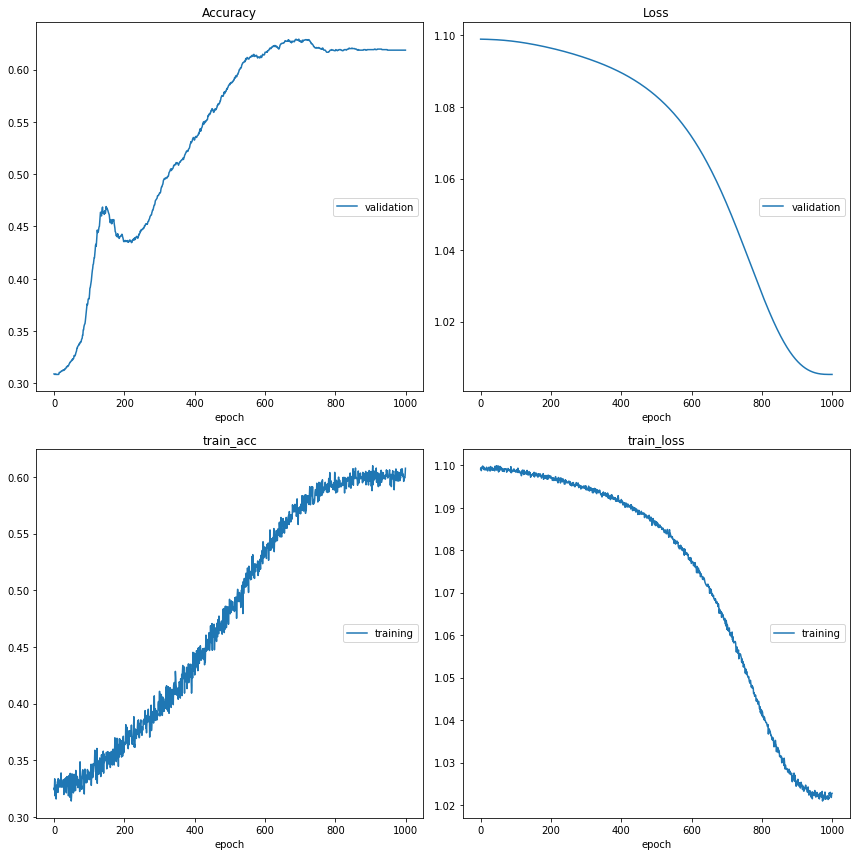

Accuracy
	validation       	 (min:    0.308, max:    0.629, cur:    0.619)
Loss
	validation       	 (min:    1.005, max:    1.099, cur:    1.005)
train_acc
	training         	 (min:    0.314, max:    0.610, cur:    0.608)
train_loss
	training         	 (min:    1.021, max:    1.100, cur:    1.023)


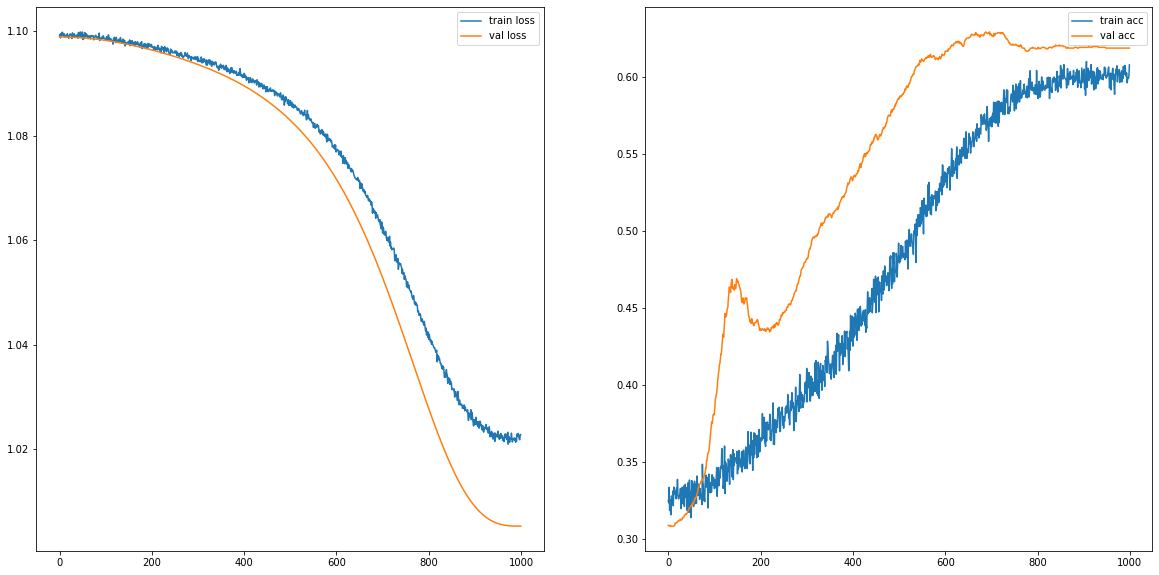

In [17]:
# epochs=1000
# batch_size=1000

# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# class NetG(nn.Module):
#     def __init__(self):
#         super(NetG, self).__init__()
#         self.m = nn.Sequential(nn.Linear(512, 5000),
#                                    nn.Dropout(0.3),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.Dropout(0.3),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.Dropout(0.3),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.Dropout(0.3),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.Dropout(0.8),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,3))

#     def forward(self, x):
#         return self.m(x)
    
# class NetDDD2(nn.Module):
#     def __init__(self):
#         super(NetDDD2, self).__init__()
#         self.m = nn.Sequential(nn.Linear(512, 5000),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,5000),
#                                    nn.ReLU(),
#                                    nn.Linear(5000,3))

#     def forward(self, x):
#         return self.m(x)

# class NetDDD(nn.Module):
#     def __init__(self):
#         super(NetDDD, self).__init__()
#         self.m = nn.Sequential(nn.Linear(512, 2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,3))

#     def forward(self, x):
#         return self.m(x)


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.m1 = nn.Sequential(nn.Linear(512, 2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,256),
#                                    nn.ReLU(),
#                                    nn.Dropout(0.3),
#                                    nn.Linear(256,3))
        
#         self.m2 = nn.Sequential(nn.Linear(512, 256),
#                                    nn.ReLU(),
#                                    nn.Linear(256,3))
#         self.m3 = nn.Sequential(nn.Linear(512, 3))

        
#         self.m4 = nn.Sequential(nn.Linear(512, 2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,256),
#                                    nn.ReLU(),
#                                    nn.Dropout(0.3),
#                                    nn.Linear(256,3))
        
#         self.m5 = nn.Sequential(nn.Linear(512, 2048),
#                                    nn.ReLU(),
#                                    nn.Linear(2048,256),
#                                    nn.ReLU(),
#                                    nn.Dropout(0.8),
#                                    nn.Linear(256,3))

#         self.fc = nn.Linear(3*5,3)

#     def forward(self, x):
#         a = torch.cat((self.m1(x),self.m2(x),self.m3(x),self.m4(x),self.m5(x)),1)
#         return self.fc(nn.Dropout(0.3)(nn.ReLU()(a)))

# model = NetG().to(device)
# lr = 3e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)


# train_losses=[]
# val_losses=[]
# train_accs=[]
# val_accs=[]

# liveloss = PlotLosses()

# for epoch in range(1, epochs + 1):
#     model.train()
#     train_loss=0
#     correct=0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#         pred = output.argmax(dim=1, keepdim=True)
#         correct += pred.eq(target.view_as(pred)).sum().item()
#         train_loss+=loss.item()
#     train_loss/=len(train_loader)
#     acc = correct / len(train_loader.dataset)
#     train_losses.append(train_loss)
#     train_accs.append(acc)
    
#     model.eval()
#     val_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             vl=criterion(output, target).item()
#             val_loss += vl
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
        

#     val_loss /= float(len(val_loader))
#     val_acc = correct / len(val_loader.dataset)
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)
    
#     logs={}
#     logs['train_loss'] = train_loss
#     logs['val_loss'] = val_loss
#     logs['train_acc'] = acc
#     logs['val_acc'] = val_acc
    
#     liveloss.update(logs)
#     if epoch%5==0:
#         liveloss.send()
# #     if epoch%10==0:
# #         print("Epoch %3d Train loss: %f Acc: %f    Val loss: %f Acc: %f"%(epoch, train_loss, acc, val_loss, val_acc))
# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# plt.plot(train_losses, label='train loss')
# plt.plot(val_losses, label='val loss')
# plt.legend();
# plt.subplot(1,2,2)
# plt.plot(train_accs, label='train acc')
# plt.plot(val_accs, label='val acc')
# plt.legend();
# # plt.ylim(0,1);

In [25]:
submission_embeddings = [literal_eval(embedding)  for embedding in submission['embeddings'].values]

In [28]:
x = torch.Tensor(normalize_X(submission_embeddings))
x.shape

torch.Size([3001, 512])

In [29]:
x[0],x[-1]

(tensor([-0.8409, -0.7080,  0.8955,  0.0821, -0.7806,  1.6846, -0.9592, -1.2054,
          0.2916, -0.7035, -0.9031, -0.7223, -0.9760, -0.0522,  0.0509,  4.3622,
         -0.3491,  1.3022, -0.0261,  0.6695,  0.1807,  0.6553,  0.3507, -0.7700,
          0.7207, -0.1700, -0.2070, -0.3745,  2.4141, -0.9235, -0.1465,  0.3111,
         -0.3533, -1.5369, -0.6810, -1.1525, -1.2312,  1.8802, -0.6204, -0.1861,
         -0.2613, -0.7923,  1.6117,  0.5778, -1.0004, -0.5141, -1.1852,  0.6239,
         -0.0915,  1.8557, -0.9505, -0.6963, -0.4418, -0.6854, -0.7266, -0.4728,
          0.0365,  1.8291, -0.3786, -1.5218, -0.1095, -0.4343, -0.7929, -0.6069,
         -0.9494, -0.6659, -0.8841, -0.1825, -0.4424,  0.0286, -0.0188, -1.3541,
          0.4720,  1.7563,  1.8476, -0.5176, -0.1428,  2.2567, -1.1897,  0.0460,
         -0.6427, -1.2524, -0.8776, -0.2161, -0.5282, -0.9218, -0.5832,  2.4383,
         -0.2789, -0.3520, -0.8171, -0.0881, -0.3758,  0.5731,  1.1334,  0.5673,
         -1.1975,  1.3721, -

In [32]:
with torch.no_grad():
    result = model(x.cuda()).cpu()
print(result)

tensor([[ -2.7204,   5.2812,  -2.5719],
        [ -3.8292,   5.2476,  -1.4586],
        [  1.7534,   5.7894,  -7.4533],
        ...,
        [ -9.6662,   4.2819,   5.2656],
        [ -8.1008,   2.8182,   5.1773],
        [ 12.3191,   4.7282, -16.8949]])


In [33]:
# with ARGMAX (one hot)  MEAN STD
predictions = np.argmax(result,axis=1).tolist()

In [34]:
max(predictions)

2

In [35]:
def convert(a):
    if a==0:
        return 'negative'
    if a==1:
        return 'neutral'
    if a==2:
        return 'positive'

result = list(map(convert, predictions))

In [36]:
np.unique(result, return_counts=True)

(array(['negative', 'neutral', 'positive'], dtype='<U8'),
 array([ 960, 1087,  954], dtype=int64))

In [37]:
submission['label'] = result
submission

,embeddings,label
0,"[0.08109518140554428, 0.3090009093284607, 1.36...",neutral
1,"[0.6809610724449158, 1.1909409761428833, 0.892...",neutral
2,"[0.14851869642734528, 0.7872061133384705, 0.89...",neutral
3,"[0.44697386026382446, 0.36429283022880554, 0.7...",negative
4,"[1.8009324073791504, 0.26081395149230957, 0.40...",negative
...,...,...
2996,"[0.9138844609260559, 0.9460961222648621, 0.571...",negative
2997,"[0.7667452096939087, 0.7896291613578796, 0.648...",negative
2998,"[0.8158280849456787, 2.404792070388794, 0.9924...",positive
2999,"[0.4161085784435272, 0.3146701455116272, 1.139...",positive


### Saving the Predictions

In [38]:
# Saving the predictions
# !rm -rf assets
# !mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))

In [39]:
%load_ext aicrowd.magic

In [40]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/W3FEXnjccORGqbp3B8jqrYdqxMBBwh5QNXZtXL3IidM
API Key valid
Gitlab access token valid
Saved details successfully!


In [41]:
%aicrowd notebook submit -c sentiment-classification -a assets --no-verify

<IPython.core.display.Javascript object>

Using notebook: age_cls.ipynb for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...
An unexpected error occured!
cannot unpack non-iterable NoneType object
To get more information, you can run this command with -v.
To increase level of verbosity, you can go upto -vvvvv
